In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc3 as pm
import arviz as az
import pandas as pd
import scipy.linalg as sp
import seaborn as sns
print('Running on PyMC3 v{}'.format(pm.__version__))
import theano
from sklearn.model_selection import train_test_split
import shelve
import warnings

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

Running on PyMC3 v3.9.3


In [47]:
#define function for nuts and advi trace plots
def nuts_advi(X, y, ofp, y_dist, opt, test_size=0.33):
    
    k = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    y_tensor = theano.shared(y_train.astype('float64'))
    X_tensor = theano.shared(X_train.astype('float64'))

    with pm.Model() as base_model:

        # Intercept term
        β0 = pm.Normal('β0', mu=0, sd=1e5)

        # Beta coefficients for predictor variables
        β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

        # Calcuate mean from the normal variables, and add intercept
        mu = pm.math.dot(X_tensor,β) + β0

        # Pass the mu and beta with the observed data
        if y_dist == 'Gumbel':
            # Gumbel distribution 
            beta = pm.HalfCauchy('beta', 1e5)
            y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
        elif y_dist == 'Beta':
            # Beta distribution
            # Intercept term
            β0x = pm.Normal('β0x', mu=0, sd=1e5)

            # Beta coefficients for predictor variables
            βx = pm.MvNormal('βx', mu=np.zeros(k), cov=np.eye(k), shape=k)

            # Calcuate mean from the normal variables, and add intercept
            mux = pm.math.dot(X_tensor,βx) + β0x

            y_likelihood = pm.Beta('fMSE', alpha=np.abs(mu), beta=np.abs(mux), observed=y_tensor)
        #start = pm.find_MAP()

    #pm.model_to_graphviz(base_model)
    
    if opt == 'nuts':
        with base_model:
        # Variational inference with ADVI optimization
            step       = pm.NUTS(target_accept=0.95)
            trace_nuts = pm.sample(draws=4000, step=step, tune=1000, cores=4)
            idata_nuts = az.from_pymc3(trace_nuts)

        filename = ofp + '_nuts.out'
        my_shelf = shelve.open(filename, 'n')
        my_shelf['base_model'] = base_model
        my_shelf['trace_nuts'] = trace_nuts
        my_shelf['idata_nuts'] = idata_nuts
        my_shelf['X_tensor']   = X_tensor
        my_shelf['y_tensor']   = y_tensor
        my_shelf['X_train']    = X_train
        my_shelf['y_train']    = y_train
        my_shelf['X_test']     = X_test
        my_shelf['y_test']     = y_test
        my_shelf.close()
        
    elif opt == 'advi':
        map_tensor_batch = {y_tensor: pm.Minibatch(y_train, 1000), X_tensor: pm.Minibatch(X_train, 1000)}
        
        with base_model:
             fit_advi= pm.fit(method=pm.ADVI(), n=1000000, more_replacements = map_tensor_batch)
        
        trace_advi = fit_advi.sample(10000)
       
        filename = ofp + '_advi.out'
        my_shelf = shelve.open(filename, 'n')
        my_shelf['base_model'] = base_model
        my_shelf['fit_advi']   = fit_advi
        my_shelf['trace_advi'] = trace_advi
        my_shelf['X_tensor']   = X_tensor
        my_shelf['y_tensor']   = y_tensor
        my_shelf['X_train']    = X_train
        my_shelf['y_train']    = y_train
        my_shelf['X_test']     = X_test
        my_shelf['y_test']     = y_test
        my_shelf.close()

def shelf_read(filename):

    my_shelf = shelve.open(filename)
    for key in my_shelf:
        globals()[key]=my_shelf[key]
    my_shelf.close()

def trace_elbo_plot(trace_or_fit, opt):
    if opt == 'trace':
        pm.traceplot(trace_or_fit)
    elif opt == 'summary':
        pm.summary(trace_or_fit)
    elif opt =='elbo':
        elbo = pd.DataFrame(
            {'log-ELBO': -np.log(fit_advi.hist),
             'n': np.arange(fit_advi.hist.shape[0])})
        _ = sns.lineplot(y='log-ELBO', x='n', data=elbo)
    else:
        print('trace, summary, or elbo keywords should be given')
        
def model_RMSE(y_tensor, X_tensor, y_test, X_test, y_dist):
    y_tensor.set_value(y_test)
    X_tensor.set_value(X_test)
    k = X_test.shape[1]
    with pm.Model() as base_model:

            # Gumbel distribution 
            # Intercept term
            β0 = pm.Normal('β0', mu=0, sd=1e5)

            # Beta coefficients for predictor variables
            β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

            # Calcuate mean from the normal variables, and add intercept
            mu = pm.math.dot(X_tensor,β) + β0
            beta = pm.HalfCauchy('beta', 1e5)

            # Pass the mu and beta with the observed data
            if y_dist == 'Gumbel':
                y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
            elif y_dist == 'Beta':
                # Beta distribution
                # Intercept term
                β0x = pm.Normal('β0x', mu=0, sd=1e5)

                # Beta coefficients for predictor variables
                βx = pm.MvNormal('βx', mu=np.zeros(k), cov=np.eye(k), shape=k)

                # Calcuate mean from the normal variables, and add intercept
                mux = pm.math.dot(X_tensor,βx) + β0x

                y_likelihood = pm.Beta('fMSE', alpha=np.abs(mu), beta=np.abs(mux), observed=y_tensor)
            #start = pm.find_MAP()

    advi_posterior_pred = pm.fast_sample_posterior_predictive(trace_advi, model=base_model)
    advi_predictions = np.mean(advi_posterior_pred['fMSE'], axis=0)

    RMSE = np.sqrt(np.mean((advi_predictions - y_test) ** 2))
    
    return RMSE

def model_prediction(y_tensor, X_tensor, y_test, X_test, trace_nuts, trace_advi, dist):
    y_tensor.set_value(y_test)
    X_tensor.set_value(X_test)
    k = X_test.shape[1]

    with pm.Model() as base_model:

            # Gumbel distribution 
            # Intercept term
            β0 = pm.Normal('β0', mu=0, sd=1e5)

            # Beta coefficients for predictor variables
            β = pm.MvNormal('β', mu=np.zeros(k), cov=np.eye(k), shape=k)

            # Calcuate mean from the normal variables, and add intercept
            mu = pm.math.dot(X_tensor,β) + β0
            beta = pm.HalfCauchy('beta', 1e5)

            # Pass the mu and beta with the observed data
            if y_dist == 'Gumbel':
                y_likelihood = pm.Gumbel('fMSE', mu=mu, beta=beta, observed=y_tensor)
            elif y_dist == 'Beta':
                # Beta distribution
                # Intercept term
                β0x = pm.Normal('β0x', mu=0, sd=1e5)

                # Beta coefficients for predictor variables
                βx = pm.MvNormal('βx', mu=np.zeros(k), cov=np.eye(k), shape=k)

                # Calcuate mean from the normal variables, and add intercept
                mux = pm.math.dot(X_tensor,βx) + β0x
                y_likelihood = pm.Beta('fMSE', alpha=np.abs(mu), beta=np.abs(mux), observed=y_tensor)
               
    nuts_posterior_pred = pm.fast_sample_posterior_predictive(trace_nuts, model=base_model)
    nuts_predictions = np.mean(nuts_posterior_pred['fMSE'], axis=0)
    advi_posterior_pred = pm.fast_sample_posterior_predictive(trace_advi, model=base_model)
    advi_predictions = np.mean(advi_posterior_pred['fMSE'], axis=0)
    
    prediction_data = pd.DataFrame(
          {'NUTS': nuts_predictions,
          'ADVI': advi_predictions,
          'actual': y_test,
          'error_ADVI': advi_predictions - y_test,
          'error_NUTS': nuts_predictions - y_test}
         )

    RMSE_ADVI = np.sqrt(np.mean(prediction_data.error_ADVI ** 2))
    RMSE_NUTS = np.sqrt(np.mean(prediction_data.error_NUTS ** 2))
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
    sns.regplot(y='ADVI', x='NUTS', data=prediction_data,
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax1).set(title='ADVI vs NUTS', aspect=1)
    sns.regplot(y='ADVI', x='actual', data = prediction_data, 
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax2).set(title='ADVI: '+f'{RMSE_ADVI:.3f}', aspect=1)
    sns.regplot(y='NUTS', x='actual', data = prediction_data,
                   line_kws={'color': 'red', 'alpha': 0.5}, ax=ax3).set(title='NUTS: '+f'{RMSE_NUTS: 3f}', aspect=1)
    
    return prediction_data, nuts_posterior_pred, advi_posterior_pred, base_model

In [48]:
# 1 load the data sets
pr_file   = "/home/hyung/Lab/data/DL_Error/predictors.csv"
res_file  = "/home/hyung/Lab/data/DL_Error/responses.csv"
pr_data   = pd.read_csv(pr_file)
res_data  = pd.read_csv(res_file)

# Rainf_f/Precip/SWdown_min have some issue because they are all zeros
pr_data.drop(columns=['Rainf_min', 'Rainf_f_min', 'Rainf_f_max','Rainf_f_tavg', 'TotalPrecip_min'], inplace=True)
pr_data.drop(columns=['Evap_min', 'Evap_max', 'Evap_tavg'], inplace=True)
pr_data.drop(columns=['LWdown_f_max', 'LWdown_f_min', 'LWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['Qair_f_max',	'Qair_f_min', 'Qh_max',	'Qh_min'], inplace=True)
pr_data.drop(columns=['Qle_min', 'Qle_max', 'Qle_tavg'], inplace=True)
pr_data.drop(columns=['SWdown_f_min', 'SWdown_f_max', 'SWdown_f_tavg'], inplace=True)
pr_data.drop(columns=['SMOS_RFI_min', 'SoilMoist_max', 'SoilMoist_min',	'SoilMoist_tavg'], inplace=True)
pr_data.drop(columns=['Tair_f_max', 'Tair_f_min', 'Tair_f_tavg', 'aspect'], inplace=True)
pr_data.drop(columns=['Wind_f_max',	'Wind_f_min', 'Wind_f_tavg'], inplace=True)

# TC estimations with std value larger than 0.2 might be unstable
std_thred     = 0.1
mask_std_A2   = res_data['AMSR2_std'] <= std_thred
mask_std_AS   = res_data['ASCAT_std'] <= std_thred
mask_std_SMOS = res_data['SMOS_std'] <= std_thred
mask_std_SMAP = res_data['SMAP_std'] <= std_thred

# 2 clean the data sets
selected_predictors = list(pr_data.columns.values)

sel_A2   = selected_predictors.copy()
sel_A2.append('AMSR2_fMSE')
sel_AS   = selected_predictors.copy()
sel_AS.append('ASCAT_fMSE')
sel_SMOS = selected_predictors.copy()
sel_SMOS.append('SMOS_fMSE')
sel_SMAP = selected_predictors.copy()
sel_SMAP.append('SMAP_fMSE')

A2_fMSE   = pr_data.join(res_data['AMSR2_fMSE'])[sel_A2]
AS_fMSE   = pr_data.join(res_data['ASCAT_fMSE'])[sel_AS]
SMOS_fMSE = pr_data.join(res_data['SMOS_fMSE'])[sel_SMOS]
SMAP_fMSE = pr_data.join(res_data['SMAP_fMSE'])[sel_SMAP]

# select fMSE <= threshold
A2_fMSE   = A2_fMSE[mask_std_A2]
AS_fMSE   = AS_fMSE[mask_std_AS]
SMOS_fMSE = SMOS_fMSE[mask_std_SMOS]
SMAP_fMSE = SMAP_fMSE[mask_std_SMAP]
                      
# drop N/A
A2_fMSE.dropna(axis=0, how='any', inplace=True)
AS_fMSE.dropna(axis=0, how='any', inplace=True)
SMOS_fMSE.dropna(axis=0, how='any', inplace=True)
SMAP_fMSE.dropna(axis=0, how='any', inplace=True)

# Numeric, categorical predictors and response, y`
# AMSR2
A2_num   = A2_fMSE.drop(columns=['ltype', 'AMSR2_fMSE'])
A2_cat   = A2_fMSE['ltype']
A2_y     = A2_fMSE['AMSR2_fMSE']
# ASCAT
AS_num   = AS_fMSE.drop(columns=['ltype', 'ASCAT_fMSE'])
AS_cat   = AS_fMSE['ltype']
AS_y     = AS_fMSE['ASCAT_fMSE']
# SMOS
SMOS_num = SMOS_fMSE.drop(columns=['ltype', 'SMOS_fMSE'])
SMOS_cat = SMOS_fMSE['ltype']
SMOS_y   = SMOS_fMSE['SMOS_fMSE']
# SMAP
SMAP_num = SMAP_fMSE.drop(columns=['ltype', 'SMAP_fMSE'])
SMAP_cat = SMAP_fMSE['ltype']
SMAP_y   = SMAP_fMSE['SMAP_fMSE']

all_predictors = SMAP_num.columns.values

# Standardize numeric/response columns, to mean 0 variance 1
# AMSR2
A2_mean       = A2_num.mean()
A2_std        = A2_num.std()
A2_num_scaled = np.array((A2_num - A2_mean) / A2_std)
A2_y_mean     = A2_y.mean()
A2_y_std      = A2_y.std()
A2_y_scaled   = np.array((A2_y - A2_y_mean) / A2_y_std)
# ASCAT
AS_mean       = AS_num.mean()
AS_std        = AS_num.std()
AS_num_scaled = np.array((AS_num - AS_mean) / AS_std)
AS_y_mean     = AS_y.mean()
AS_y_std      = AS_y.std()
AS_y_scaled   = np.array((AS_y - AS_y_mean) / AS_y_std)
# SMOS
SMOS_mean       = SMOS_num.mean()
SMOS_std        = SMOS_num.std()
SMOS_num_scaled = np.array((SMOS_num - SMOS_mean) / SMOS_std)
SMOS_y_mean     = SMOS_y.mean()
SMOS_y_std      = SMOS_y.std()
SMOS_y_scaled   = np.array((SMOS_y - SMOS_y_mean) / SMOS_y_std)
# SMAP
SMAP_mean        = SMAP_num.mean()
SMAP_std         = SMAP_num.std()
SMAP_num_scaled  = np.array((SMAP_num - SMAP_mean) / SMAP_std)
SMAP_y_mean      = SMAP_y.mean()
SMAP_y_std       = SMAP_y.std()
SMAP_y_scaled    = np.array((SMAP_y - SMAP_y_mean) / SMAP_y_std)

In [ ]:
# run VI and Sampling (y with scaling)
dist = 'Gumbel'
test_size = 0.33
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/A2' 
nuts_advi(A2_num_scaled, A2_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(A2_num_scaled, A2_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/AS' 
nuts_advi(AS_num_scaled, AS_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(AS_num_scaled, AS_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS' 
nuts_advi(SMOS_num_scaled, SMOS_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(SMOS_num_scaled, SMOS_y_scaled, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP' 
nuts_advi(SMAP_num_scaled, SMAP_y_scaled, ofp, dist, 'advi', test_size)
nuts_advi(SMAP_num_scaled, SMAP_y_scaled, ofp, dist, 'nuts', test_size)

In [49]:
# run VI and Sampling (y without scaling)
dist = 'Beta'
test_size = 0.33
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/A2_ywos_Beta' 
nuts_advi(A2_num_scaled, A2_y.values, ofp, dist, 'advi', test_size)
#nuts_advi(A2_num_scaled, A2_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/AS_ywos_Beta' 
nuts_advi(AS_num_scaled, AS_y.values, ofp, dist, 'advi', test_size)
#nuts_advi(AS_num_scaled, AS_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_Beta' 
nuts_advi(SMOS_num_scaled, SMOS_y.values, ofp, dist, 'advi', test_size)
#nuts_advi(SMOS_num_scaled, SMOS_y.values, ofp, dist, 'nuts', test_size)

ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_Beta' 
nuts_advi(SMAP_num_scaled, SMAP_y.values, ofp, dist, 'advi', test_size)
#nuts_advi(SMAP_num_scaled, SMAP_y.values, ofp, dist, 'nuts', test_size)

Interrupted at 14,459 [1%]: Average Loss = 1,038.6


Interrupted at 7,125 [0%]: Average Loss = 959.81


Interrupted at 4,817 [0%]: Average Loss = 1,039.8


KeyboardInterrupt: 

In [260]:
# Check hdi 3% and 97%
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_nuts.out'    
shelf_read(filename)
summary_nuts = pm.summary(trace_nuts)
hdi_3  = summary_nuts['hdi_3%'][1:-1]
hdi_97 = summary_nuts['hdi_97%'][1:-1]
invalid_p_i = np.where((hdi_3 < 0) & (hdi_97 > 0))
valid_p_i   = np.where(~((hdi_3 <0) & (hdi_97 > 0)))

In [226]:
# Run model with selected variables
top_sel = 10
top_sel_i = np.argsort(np.abs(summary_nuts['mean'][1:-1].values[valid_p_i])) < top_sel
top_sel_i = valid_p_i[0][top_sel_i]SMAP_num_scaled_sel = np.squeeze(SMAP_num_scaled[:,valid_p_i])
SMAP_num_scaled_sel = np.squeeze(SMAP_num_scaled[:,valid_p_i])
SMAP_num_scaled_topsel = np.squeeze(SMAP_num_scaled[:,top_sel_i])

# It does not chage much
ofp = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_topsel' 
nuts_advi(SMAP_num_scaled_topsel, SMAP_y.values, ofp, dist, 'advi', 0.7)
#nuts_advi(SMAP_num_scaled_sel, SMAP_y.values, ofp, dist, 'nuts', 0.7)

In [32]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMAP_ywos_topsel_advi.out'    
shelf_read(filename)
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, y_dist)
print(f'RMSE for the predictions = {RMSE:.3f}')

RMSE for the predictions = 0.152


In [227]:
summary_nuts['mean'][1:-1].values[top_sel_i]

array([ 0.059, -0.044, -0.205, -0.006, -0.02 , -0.027,  0.175, -0.025,
        0.011, -0.005])

In [228]:
all_predictors[top_sel_i]

array(['LAI_tavg', 'Qh_tavg', 'RadT_tavg', 'SMAP_rc_min', 'SoilTemp_max',
       'SoilTemp_min', 'SoilTemp_tavg', 'albedo_max', 'albedo_std',
       'irrfrac'], dtype=object)

(array([  1.,   0.,   4.,   5.,   4.,   7.,  14.,  21.,  36.,  42.,  77.,
         93., 130., 184., 214., 301., 367., 484., 534., 661., 739., 868.,
        941., 981., 957., 993., 940., 946., 920., 769., 690., 667., 541.,
        412., 349., 301., 229., 177., 115.,  92.,  70.,  36.,  30.,  23.,
         14.,  12.,   4.,   1.,   0.,   4.]),
 array([0.02803123, 0.02925283, 0.03047444, 0.03169604, 0.03291764,
        0.03413925, 0.03536085, 0.03658246, 0.03780406, 0.03902566,
        0.04024727, 0.04146887, 0.04269047, 0.04391208, 0.04513368,
        0.04635528, 0.04757689, 0.04879849, 0.0500201 , 0.0512417 ,
        0.0524633 , 0.05368491, 0.05490651, 0.05612811, 0.05734972,
        0.05857132, 0.05979293, 0.06101453, 0.06223613, 0.06345774,
        0.06467934, 0.06590094, 0.06712255, 0.06834415, 0.06956575,
        0.07078736, 0.07200896, 0.07323057, 0.07445217, 0.07567377,
        0.07689538, 0.07811698, 0.07933858, 0.08056019, 0.08178179,
        0.0830034 , 0.084225  , 0.0854466 , 0.

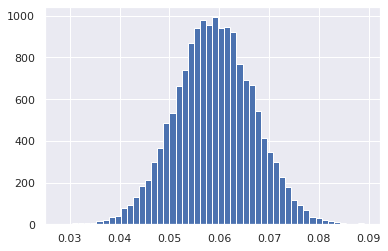

In [255]:
plt.hist((trace_nuts['β'][:,top_sel_i[0]]), 50)

In [13]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_nuts.out'    
shelf_read(filename)
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_advi.out'    
shelf_read(filename)
summary_nuts = pm.summary(trace_nuts)
hdi_3  = summary_nuts['hdi_3%'][1:-1]
hdi_97 = summary_nuts['hdi_97%'][1:-1]
invalid_p_i = np.where((hdi_3 < 0) & (hdi_97 > 0))
all_predictors[invalid_p_i]

array(['Rainf_max', 'SMAP_rc_tavg', 'SMAP_vo_max', 'albedo_std'],
      dtype=object)

In [42]:
shelf_read(filename)
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_advi_beta.out'    
shelf_read(filename)
dist = 'Beta'
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, dist)
print(f'RMSE for the predictions = {RMSE:.3f}')

RMSE for the predictions = 0.519


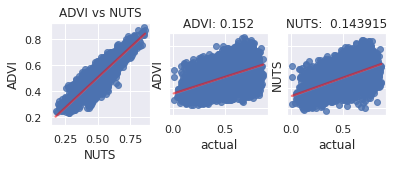

In [17]:
prediction_data, nuts_posterior_pred, advi_posterior_pred, base_model = model_prediction(y_tensor, X_tensor, y_test, X_test, trace_nuts, trace_advi, dist)

(0.0, 5.0)

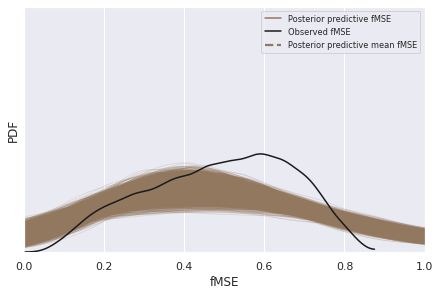

In [43]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_advi_beta.out'    
shelf_read(filename)
dist = 'Beta'
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, dist)
print(f'RMSE for the predictions = {RMSE:.3f}')
ppc_data = az.from_pymc3(posterior_predictive=advi_posterior_pred, model=base_model)
ax = az.plot_ppc(data=ppc_data, color="C5")
#ax.set_xlim(0,1)
ax.set_ylabel('PDF')
ax.set_ylim(0, 5)

RMSE for the predictions = 0.152


(0.0, 5.0)

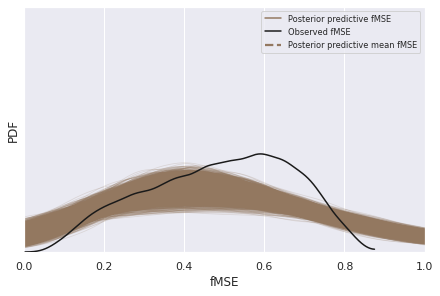

In [45]:
filename = '/home/hyung/Lab/libs/python/DL_Error_data/SMOS_ywos_advi.out'    
shelf_read(filename)
dist = 'Gumbel'
RMSE = model_RMSE(y_tensor, X_tensor, y_test, X_test, dist)
print(f'RMSE for the predictions = {RMSE:.3f}')
ppc_data = az.from_pymc3(posterior_predictive=advi_posterior_pred, model=base_model)
ax = az.plot_ppc(data=ppc_data, color="C5")
ax.set_xlim(0,1)
ax.set_ylabel('PDF')
ax.set_ylim(0, 5)

array([<AxesSubplot:>], dtype=object)

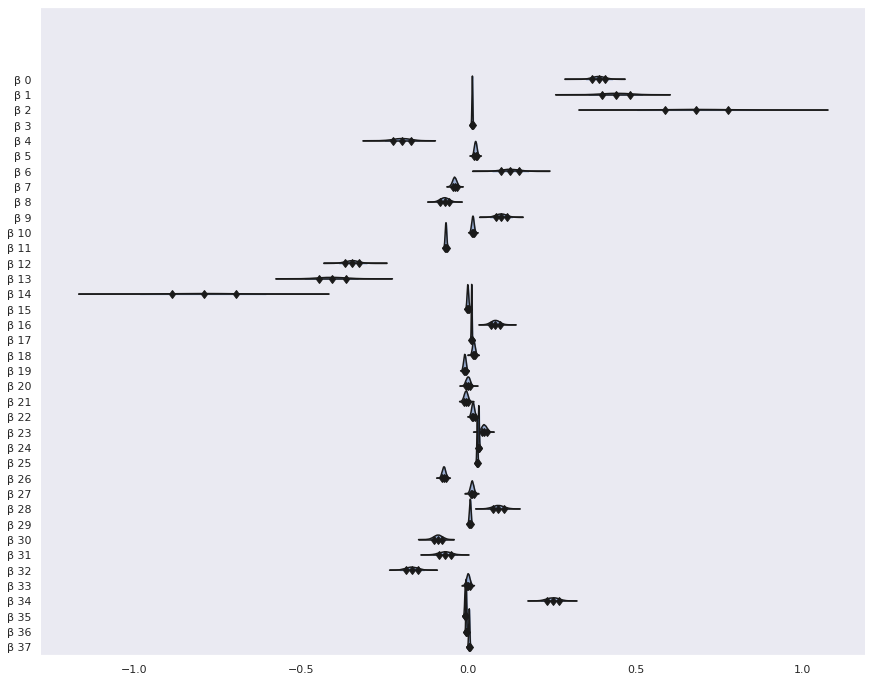

In [22]:
az.plot_forest(trace_nuts, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

In [284]:
ppc_data = az.from_pymc3(posterior_predictive=nuts_posterior_pred, model=base_model)

(0.0, 5.0)

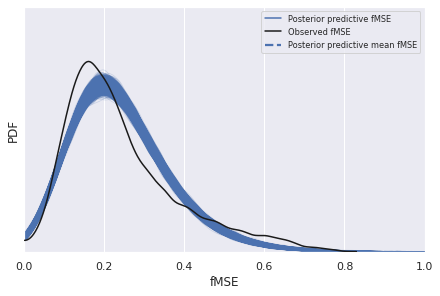

In [344]:
ax = az.plot_ppc(data=ppc_data)
ax.set_xlim(0,1)
ax.set_ylabel('PDF')
ax.set_ylim(0, 5)

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=advi_posterior_pred, model=base_model))

In [ ]:
param_samples_NUTS = pd.DataFrame(
    {'β0': trace_sampling.get_values('β0')[:, ], 
     'β': trace_sampling.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_NUTS).set_title('NUTS')

In [ ]:
param_samples_ADVI = pd.DataFrame(
    {'β0': advi_trace.get_values('β0')[:, ], 
     'β': advi_trace.get_values('β')[:, 0]})

_ = sns.scatterplot(x='β0', y='β', data=param_samples_ADVI).set_title('ADVI')

In [ ]:
PPC_SAMPLES = 20000
advi_trace  = advi_fit.sample(PPC_SAMPLES)

# Forest Plots to show the distributions for each of the predictors
#with advi_model:
az.plot_forest(advi_trace, var_names=['β'], combined=True,
               kind='ridgeplot', ridgeplot_quantiles=[0.16, 0.5, 0.84],
               ridgeplot_truncate=False, hdi_prob=0.95,
               ridgeplot_overlap=3, ridgeplot_alpha=0.5)

with base_model:
    idata_advi = az.from_pymc3(advi_trace)
az.summary(idata_advi, round_to=4, var_names = ['β'])

In [ ]:
all_predictors

In [ ]:
np.where(all_predictors == 'RadT_max')

In [ ]:
burnin = 100
sample_intercept = test_trace['β0'][burnin:]
sample_betas = test_trace['β'][burnin:]
advi_intercept = advi_trace_test['β0']
advi_betas = advi_trace_test['β']

# Plot posteriors

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 4), dpi=150, constrained_layout=False)

for ax, estimate_sampling, estimate_advi in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(k)],
                               [advi_intercept] + [advi_betas[:,i] for i in range(k)]):
    
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    #ax.set_title(title, fontsize=12)

    #ax.set_xlabel(xlabel, fontsize=12)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

In [ ]:
all_predictors[37]